# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.diffusion_model import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-14 11:53:47.629689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 11:53:47.659190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-14 11:53:48.722504: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:53:48.726485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:53:48.726614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 128
EPOCHS = int(config_hp["epochs"])
T = 300
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-14 11:53:48.738149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:53:48.738313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:53:48.738377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


2024-04-14 11:53:49.937404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


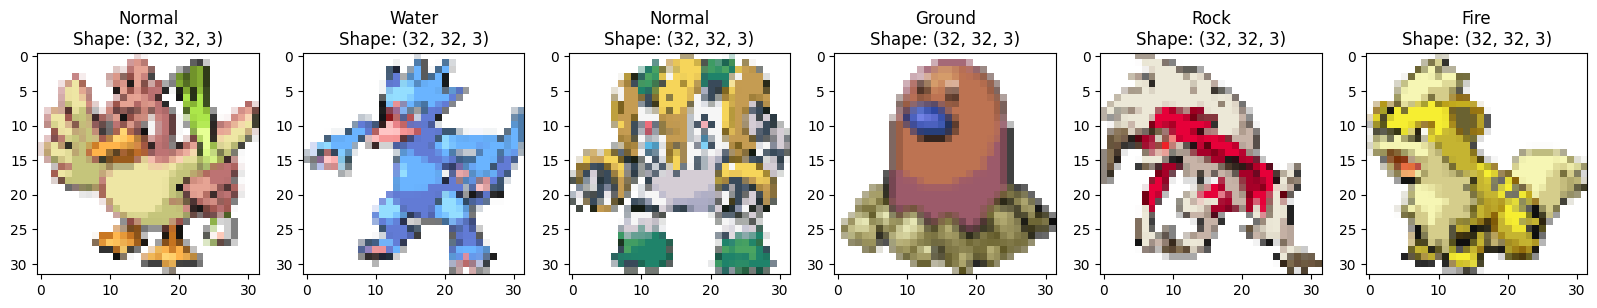

2024-04-14 11:53:50.472069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 32, 32, 3)
(32, 18)


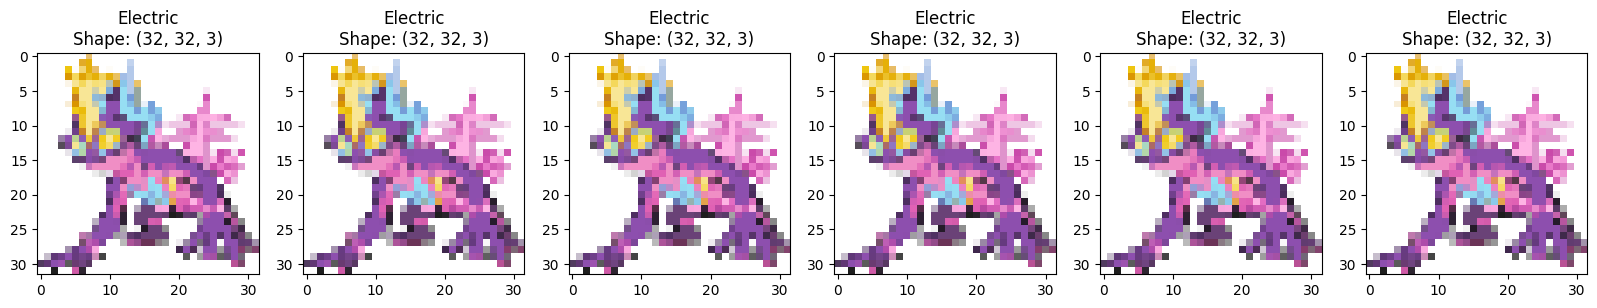

2024-04-14 11:53:50.872246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-14 11:53:50.873334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# get only one image of the dataset
dataset_example = poke_dataset.take(1)

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(256).batch(32)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [7]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)

Epoch 1/100


NotImplementedError: Cannot convert a symbolic tf.Tensor (add_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

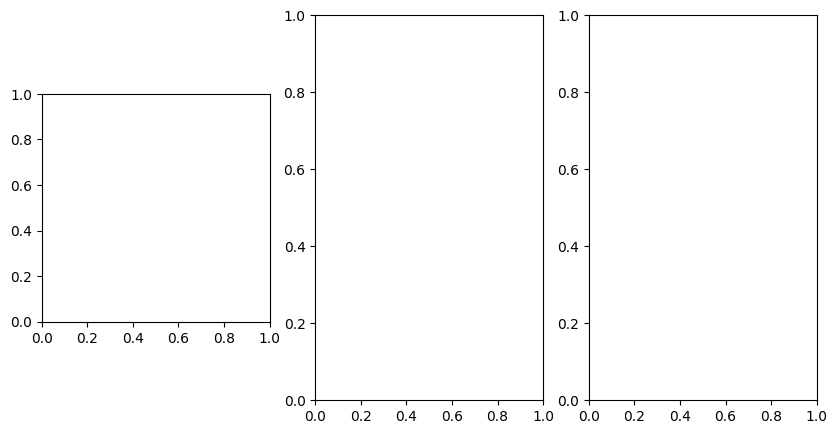

In [8]:
"""
diffusion_model.py

Functionality: This file contains the code to define the DiffusionModel class that adds the
diffusion functionality to the defined model.

"""

# Imports
# =====================================================================
import configparser
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.utils.utils import string_to_onehot, onehot_to_string, PROJECT_DIR


# Set up
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# IMG_SIZE = int(config["hyperparameters"]["img_size"])
# NUM_CLASSES = int(config["hyperparameters"]["num_classes"])
# BATCH_SIZE = int(config["hyperparameters"]["batch_size"])
# EPOCHS = int(config["hyperparameters"]["epochs"])

# TIMESTEPS = int(config["hyperparameters"]["T"])  # Number of diffusion steps
SCHEDULER = config["hyperparameters"]["scheduler"]
BETA_START = float(config["hyperparameters"]["beta_start"])
BETA_END = float(config["hyperparameters"]["beta_end"])
S = float(config["hyperparameters"]["s"])  # Scale factor for the variance curve


class DiffusionModel(tf.keras.Model):
    """
    DiffusionModel class

    Attributes:

    - model (tf.keras.Model): The base model to which the diffusion process is added.
    - img_size (int): The size of the input images.
    - num_classes (int): The number of classes in the dataset.
    - T (int): The total number of diffusion steps.
    - beta_start (float): The starting value of beta (noise level).
    - beta_end (float): The ending value of beta (noise level).
    - s (float): The scale factor for the variance curve in the 'cosine' scheduler.
    - scheduler (str): The type of noise schedule ('cosine' or 'linear').

    Methods:

    - train_step(data): The training step for the diffusion model.
    - predict_step(data): The prediction step for the diffusion model.
    - plot_samples(num_samples, poke_type): Generate and plot samples from the diffusion model.
    - forward_diffusion(x_0, t, T, scheduler, beta_start, beta_end, s): Simulate the forward diffusion process.
    - beta_scheduler(scheduler, T, beta_start, beta_end, s): Generate a schedule for beta values according to the specified type.

    """

    def __init__(
        self,
        model: tf.keras.Model,
        img_size: int,
        num_classes: int,
        T: int,
        beta_start: float,
        beta_end: float,
        s: float,
        scheduler: str,
    ):

        super().__init__()
        self.model = model
        self.img_size = img_size
        self.num_classes = num_classes
        self.T = T
        self.scheduler = scheduler
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.s = s

        self.beta = self.beta_scheduler(scheduler, T, beta_start, beta_end, s)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = tf.math.cumprod(self.alpha)

    def train_step(self, data):
        """
        Algorithm 1: The training step for the diffusion model.

        Args:
            data (tuple): A tuple containing the input data and labels.

        Returns:
            dict: A dictionary containing the training loss.
        """

        # Rename the variables for easier access
        loss_fn = self.loss
        optimizer = self.optimizer
        T = self.T  # Total diffusion steps
        scheduler = self.scheduler
        beta_start = self.beta_start
        beta_end = self.beta_end
        s = self.s  # Scale factor for the variance curve
        alpha_cumprod = self.alpha_cumprod

        # Unpack the data
        input_data, input_label = data

        # 1: repeat ------

        # 3: t ~ U(0, T)
        # Generate a random timestep for each image in the batch
        t = np.random.randint(0, T)
        normalized_t = tf.fill([input_data.shape[0], 1], tf.cast(t, tf.float32) / T)

        # 2: x_0 ~ q(x_0)
        noised_data = self.forward_diffusion(
            input_data,
            t,
            T,
            scheduler,
            beta_start,
            beta_end,
            s,
        )

        # 4: eps_t ~ N(0, I)
        target_noise = noised_data - input_data * tf.sqrt(alpha_cumprod[t]) / tf.sqrt(
            1 - alpha_cumprod[t]
        )

        # 5: Take a gradient descent step on
        with tf.GradientTape() as tape:
            predicted_noise = self.model(
                [noised_data, normalized_t, input_label], training=True
            )
            loss = loss_fn(target_noise, predicted_noise)

        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # 6: until convergence ------

        _, axis = plt.subplots(1, 3, figsize=(10, 5))
        axis[0].imshow(input_data * 0.5 + 0.5)
        axis[0].set_title("input")
        axis[1].imshow(target_noise * 0.5 + 0.5)
        axis[1].set_title("target noise")
        axis[2].imshow(predicted_noise * 0.5 + 0.5)
        axis[2].set_title("predicted noise")
        plt.show()

        # Update and return training metrics
        return {"loss": loss}

    def predict_step(self, data):
        """
        Algorithm 2: (sampling) The prediction step for the diffusion model.

        Args:
            data (tuple): A tuple containing the input data and labels.

        Returns:
            tf.Tensor: The final denoised image.

        """

        # Rename the variables for easier access
        T = self.T  # Total diffusion steps
        alpha = self.alpha
        alpha_cumprod = self.alpha_cumprod

        # Starting from pure noise
        x_t, y_t = data  # 1: x_T ~ N(0, I)

        # Reverse the diffusion process
        # 2: for t = T − 1, . . . , 1 do
        time.sleep(0.4)
        for t in tqdm(reversed(range(1, T)), desc="Sampling sprite", total=T - 1):
            normalized_t = tf.fill([tf.shape(x_t)[0], 1], tf.cast(t, tf.float32) / T)

            # Sample z
            # 3: z ~ N(0, I) if t > 1, else z = 0
            z = tf.random.normal(shape=tf.shape(x_t)) if t > 1 else tf.zeros_like(x_t)

            # Calculate the predicted noise
            predicted_noise = self.model([x_t, normalized_t, y_t], training=False)

            # Calculate x_{t-1}
            # 4: x_{t-1} = (x_t - (1 - alpha_t) / sqrt(1 - alpha_cumprod_t) * eps_theta) / sqrt(alpha_t) + sigma_t * z
            sigma_t = tf.sqrt(1 - alpha_cumprod[t])
            x_t = (
                x_t - (1 - alpha[t]) / tf.sqrt(1 - alpha_cumprod[t]) * predicted_noise
            ) / tf.sqrt(alpha[t]) + sigma_t * z

        # 5: end for
        # Return the final denoised image
        return x_t  # 6: return x_0

    def plot_samples(self, num_samples: int = 5, poke_type: str = None):
        """
        Generate and plot samples from the diffusion model.

        Args:
            num_samples (int): The number of samples to generate and plot.
            poke_type (str): The type of Pokemon to generate samples for. If None, a random type is chosen.
        """

        _, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 3))

        # TODO: TRATAR LOS TIPOS CUANDO VENGAN VARIOS Y NO SOLO UNO
        if num_samples == 1:
            axs = [axs]  # Make axs iterable when plotting only one sample

        # Generate and plot the samples
        # =====================================================================
        for i in range(num_samples):
            tqdm.write(f"Generating sample {i + 1}/{num_samples}")

            # Start with random noise as input
            start_noise = tf.random.normal([1, self.img_size, self.img_size, 3])

            # Set the label for the sample(s)
            if poke_type is not None:
                y_label = string_to_onehot(poke_type)
            else:
                random_index = tf.random.uniform(
                    shape=[], minval=0, maxval=NUM_CLASSES, dtype=tf.int32
                )
                y_label = tf.one_hot(random_index, NUM_CLASSES)

            y_label = tf.reshape(y_label, [1, NUM_CLASSES])

            # Generate the sample
            sample = self.predict_step((start_noise, y_label))
            sample = tf.squeeze(sample)  # remove the batch dimension

            # Scale to [0, 1] for plotting
            sample = (sample - tf.reduce_min(sample)) / (
                tf.reduce_max(sample) - tf.reduce_min(sample)
            )

            # Plot the sample
            axs[i].imshow(sample)
            axs[i].title.set_text(onehot_to_string(y_label))
            axs[i].axis("off")

        return plt.show()

    @staticmethod
    def forward_diffusion(
        x_0: tf.Tensor,
        t: int,
        T: int,
        scheduler: str,
        beta_start: float,
        beta_end: float,
        s: float,  # **config["training_params"] TODO
    ) -> tf.Tensor:
        """Simulate the forward diffusion process by adding noise to the input image.

        Args:
            x_0 (tf.Tensor): The initial image tensor.
            t (int): The current timestep.
            T (int): The total number of diffusion timesteps.
            scheduler (str): The type of noise schedule ('cosine' or 'linear').
            beta_start (float): The starting value of beta (noise level).
            beta_end (float): The ending value of beta (noise level).
            s (float): The scale factor for the variance curve in the 'cosine' scheduler.

        Returns:
            tf.Tensor: The diffused image tensor at timestep t.
        """
        # Calculate the noise schedule for beta values
        beta = DiffusionModel.beta_scheduler(
            scheduler=scheduler, T=T, beta_start=beta_start, beta_end=beta_end, s=s
        )
        alpha = 1.0 - beta
        alpha_cumprod = tf.math.cumprod(alpha)

        # Apply the diffusion process: x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1-alpha_cumprod_t) * noise
        noise = tf.random.normal(shape=tf.shape(x_0))
        x_t = tf.sqrt(alpha_cumprod[t]) * x_0 + tf.sqrt(1 - alpha_cumprod[t]) * noise

        return x_t

    @staticmethod
    def beta_scheduler(
        scheduler: str, T: int, beta_start: float, beta_end: float, s: float
    ) -> tf.Tensor:
        """
        Generates a schedule for beta values according to the specified type ('linear' or 'cosine').

        Args:
            scheduler (str): The type of schedule to use. Options are "linear" or "cosine".
            T (int): Total number of timesteps.
            beta_start (float): Starting value of beta.
            beta_end (float): Ending value of beta.
            s (float): Scale factor for the variance curve, used in the 'cosine' scheduler.

        Returns:
            tf.Tensor: The beta values for each timestep.
        """

        if scheduler == "linear":
            beta = tf.linspace(beta_start, beta_end, T)

        elif scheduler == "cosine":

            def f(t):
                return tf.cos((t / T + s) / (1 + s) * tf.constant(np.pi * 0.5)) ** 2

            t = np.arange(0, T + 1)
            alphas_cumprod = f(t) / f(0)
            beta = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
            beta = tf.clip_by_value(beta, 0.0001, 0.999)

        else:
            raise ValueError(f"Unsupported scheduler: {scheduler}")

        return beta


# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

model.fit(poke_dataset, epochs=EPOCHS)

In [ ]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

In [ ]:
model.fit(poke_dataset, epochs=EPOCHS)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Epoch 1/100


AttributeError: 'NoneType' object has no attribute 'items'

Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:39<00:00, 25.00it/s]


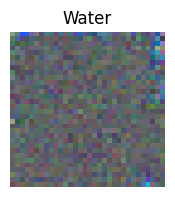

In [ ]:
model.plot_samples(1, "Normal")

## Train Diffusion Model

### Training

In [ ]:
# Algorithm 1: Training
# =====================================================================
def training(
    model: tf.keras.models.Model,
    dataset: tf.data.Dataset,
    optimizer: tf.keras.optimizers.Optimizer,
    loss_fn: tf.keras.losses.Loss,
    total_epochs: int = 10,
    scheduler: str = "cosine",
    T: int = 100,
) -> None:
    """
    Performs the training loop.

    :param model: The model to train.
    :param dataset: The training dataset.
    :param optimizer: The optimizer to use.
    :param loss_fn: The loss function to use.
    :param total_epochs: The number of epochs to train for.
    :param scheduler: The type of schedule to use. Options are "linear" or "cosine".
    :param T: The number of timesteps to sample for.
    :return: None
    """

    # Get scheduler values
    beta = beta_scheduler(scheduler, T, beta_start, beta_end)  # Get beta
    alpha = 1.0 - beta  # Get alpha
    alpha_cumprod = np.cumprod(alpha)  # Get alpha cumulative product

    for epoch in trange(
        prev_epoch,
        total_epochs,
        desc=f"Training",
        total=total_epochs - prev_epoch,
        leave=True,
    ):  # 1: repeat (iterations through the epochs)
        for step, input_data in tqdm(
            enumerate(dataset),
            desc=f"Epoch {epoch+1}/{total_epochs}",
            total=len(dataset),
            leave=True,
        ):  # 1: repeat (iterations through the batches)
            # Generate a single timestep for one entire batch
            t = np.random.randint(0, T)
            normalized_t = np.full(
                (input_data.shape[0], 1), t / T, dtype=np.float32
            )  # 3: t ~ U(0, T)

            # Get the target noise
            noised_data = forward_diffusion(input_data, t, scheduler)  # 2: x_0 ~ q(x_0)
            target_noise = noised_data - input_data * np.sqrt(
                alpha_cumprod[t]
            )  # 4: eps_t ~ N(0, I)

            # 5: Take a gradient descent step on
            with tf.GradientTape() as tape:
                predicted_noise = model(
                    [noised_data, normalized_t], training=True
                )  # eps_theta -> model(x_t, t/T)
                loss = loss_fn(
                    target_noise, predicted_noise
                )  # gradient of the loss (MSE(eps_t, eps_theta))
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # if step % 2 == 0:
            #     plt.subplot(1,3,1)
            #     plt.imshow(input_data[0])
            #     plt.title('input')
            #     plt.subplot(1,3,2)
            #     plt.imshow(noised_data[0])
            #     plt.title('noised')
            #     plt.subplot(1,3,3)
            #     plt.imshow(target_noise[0])
            #     plt.title('target')
            #     plt.show()

            # f, axis = plt.subplots(1, 2, figsize=(10, 5))
            # axis[0].imshow(target_noise[0]*0.5+0.5)
            # axis[0].set_title('target noise')
            # axis[1].imshow(predicted_noise[0]*0.5+0.5)
            # axis[1].set_title('predicted noise')
            # plt.show()

        print(f"EPOCH {epoch+1} LOSS: {loss.numpy():.4f} \n{'='*69}")

        # # Save the model and it's weights at the end of every 20 epochs
        # if (epoch+1) % 20 == 0:
        #     print(f"\tSaving model and its _weights in epoch {epoch+1}")
        #     model.save(f'{folder_epoch}/diffusion_{scheduler}_{epoch+1}.h5')
        #     model.save_weights(f'{folder_epoch}/weights{scheduler}_{epoch+1}.h5')

        # Sample and plot every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("\tSampling images...")
            plot_samples(model, num_samples=3, scheduler=scheduler, T=T)